# Data Exploration

This stage aims to be part of the designing the structure of data for modern MLOps practices.

# Data

- There are many NetCDF files sums to ~1GB.
- Spatial resolution is 92y to 109x with 15 minutes of temporal resolution.


#### Storing many files in NetCDF files are not efficient by **high costs** due to billing of the cloud services are mostly **per operation** for files.


##### 🎯 Why Convert to Zarr?

| Aspect | Many Small NetCDF Files | Single Large NetCDF | **Zarr (Recommended)** |
|--------|------------------------|---------------------|----------------------|
| **Cloud Cost** | ❌ Very High (many ops) | ⚠️ Medium | ✅ Low |
| **ML Performance** | ❌ Slow (many reads) | ⚠️ Limited parallel | ✅ Fast parallel |
| **Flexibility** | ✅ Good | ❌ Must load all | ✅ Excellent |
| **Compression** | ⚠️ Per file | ✅ Good | ✅ Excellent |
| **Cloud Native** | ❌ No | ❌ No | ✅ Yes |

#### Approximate cost calculation:


##### Cost Comparison (100GB dataset)

| Strategy | Storage/Month | Operations/Month | **Total/Month** |
|----------|--------------|------------------|-----------------|
| Many small NetCDF | $1.80 | $50-200 | **$52-202** |
| Single large NetCDF | $1.80 | $5-10 | **$7-12** |
| **Zarr (Recommended)** | **$1.80** | **$2-5** | **$4-7** |



- Data will be preprocessed
    - sza preprocessing
    - converting to diffrent format & zipping
    - structuring it


In [22]:
import os
from datetime import datetime

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.utils import (
    NetCDFToZarrConverter
)
raw_data_path = "../data/raw/seviri"

In [23]:
hrv_ds_example = xr.open_mfdataset(f"{raw_data_path}/hrv_lr2*.nc") 

In [24]:
hrv_ds_example

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 52928, y: 92, x: 109)
Coordinates:
    lat      (y, x) float64 80kB dask.array<chunksize=(92, 109), meta=np.ndarray>
    lon      (y, x) float64 80kB dask.array<chunksize=(92, 109), meta=np.ndarray>
  * time     (time) datetime64[ns] 423kB 2004-01-01T08:00:00 ... 2019-12-31T1...
Dimensions without coordinates: y, x
Data variables:
    hrv      (time, y, x) float64 4GB dask.array<chunksize=(333, 31, 37), meta=np.ndarray>

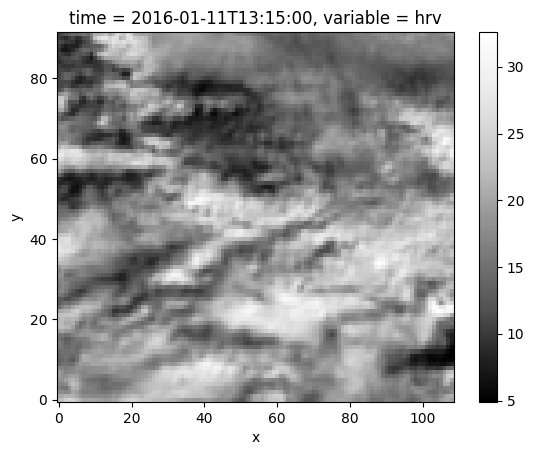

In [25]:
cmap = plt.get_cmap('Greys_r')

hrv_ds_example.isel(time=40000).to_array().plot(cmap=cmap)

In [26]:
hrv_ds_example

<xarray.Dataset> Size: 4GB
Dimensions:  (time: 52928, y: 92, x: 109)
Coordinates:
    lat      (y, x) float64 80kB dask.array<chunksize=(92, 109), meta=np.ndarray>
    lon      (y, x) float64 80kB dask.array<chunksize=(92, 109), meta=np.ndarray>
  * time     (time) datetime64[ns] 423kB 2004-01-01T08:00:00 ... 2019-12-31T1...
Dimensions without coordinates: y, x
Data variables:
    hrv      (time, y, x) float64 4GB dask.array<chunksize=(333, 31, 37), meta=np.ndarray>

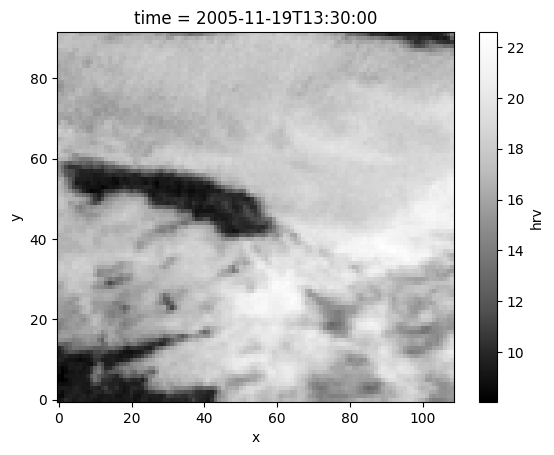

In [27]:
hrv_ds_example.sel(time=np.datetime64('2005-11-19T13:30:00'))["hrv"].plot.imshow(cmap=cmap)

### Notes over Dataset

Some data are None at specific datetime below, they will be cleaned by removing them.


working on: 19/11/2005
['hrv_lr200511.nc']
working on: 20/11/2005
['hrv_lr200511.nc']
working on: 07/11/2006
['hrv_lr200611.nc']
working on: 30/11/2006
['hrv_lr200611.nc']
working on: 19/02/2007
[]
File: [] Date: 19/02/2007 Time: 16:00:00  Unexpected error: list index out of range
working on: 17/01/2015
['hrv_lr201501.nc']
working on: 17/02/2013
['hrv_lr201302.nc']
working on: 02/11/2015
['hrv_lr201511.nc']
working on: 12/11/2015
['hrv_lr201511.nc']
working on: 23/11/2015
['hrv_lr201511.nc']
working on: 20/01/2016
['hrv_lr201601.nc']
working on: 21/01/2016
['hrv_lr201601.nc']
working on: 30/12/2016
['hrv_lr201612.nc']
working on: 18/02/2017
['hrv_lr201702.nc']
working on: 17/02/2017
['hrv_lr201702.nc']
working on: 05/02/2019
['hrv_lr201902.nc']
File: ['hrv_lr201902.nc'] Date: 05/02/2019 Time: 16:00:00  Unexpected error: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."
working on: 13/02/2019
['hrv_lr201902.nc']
File: ['hrv_lr

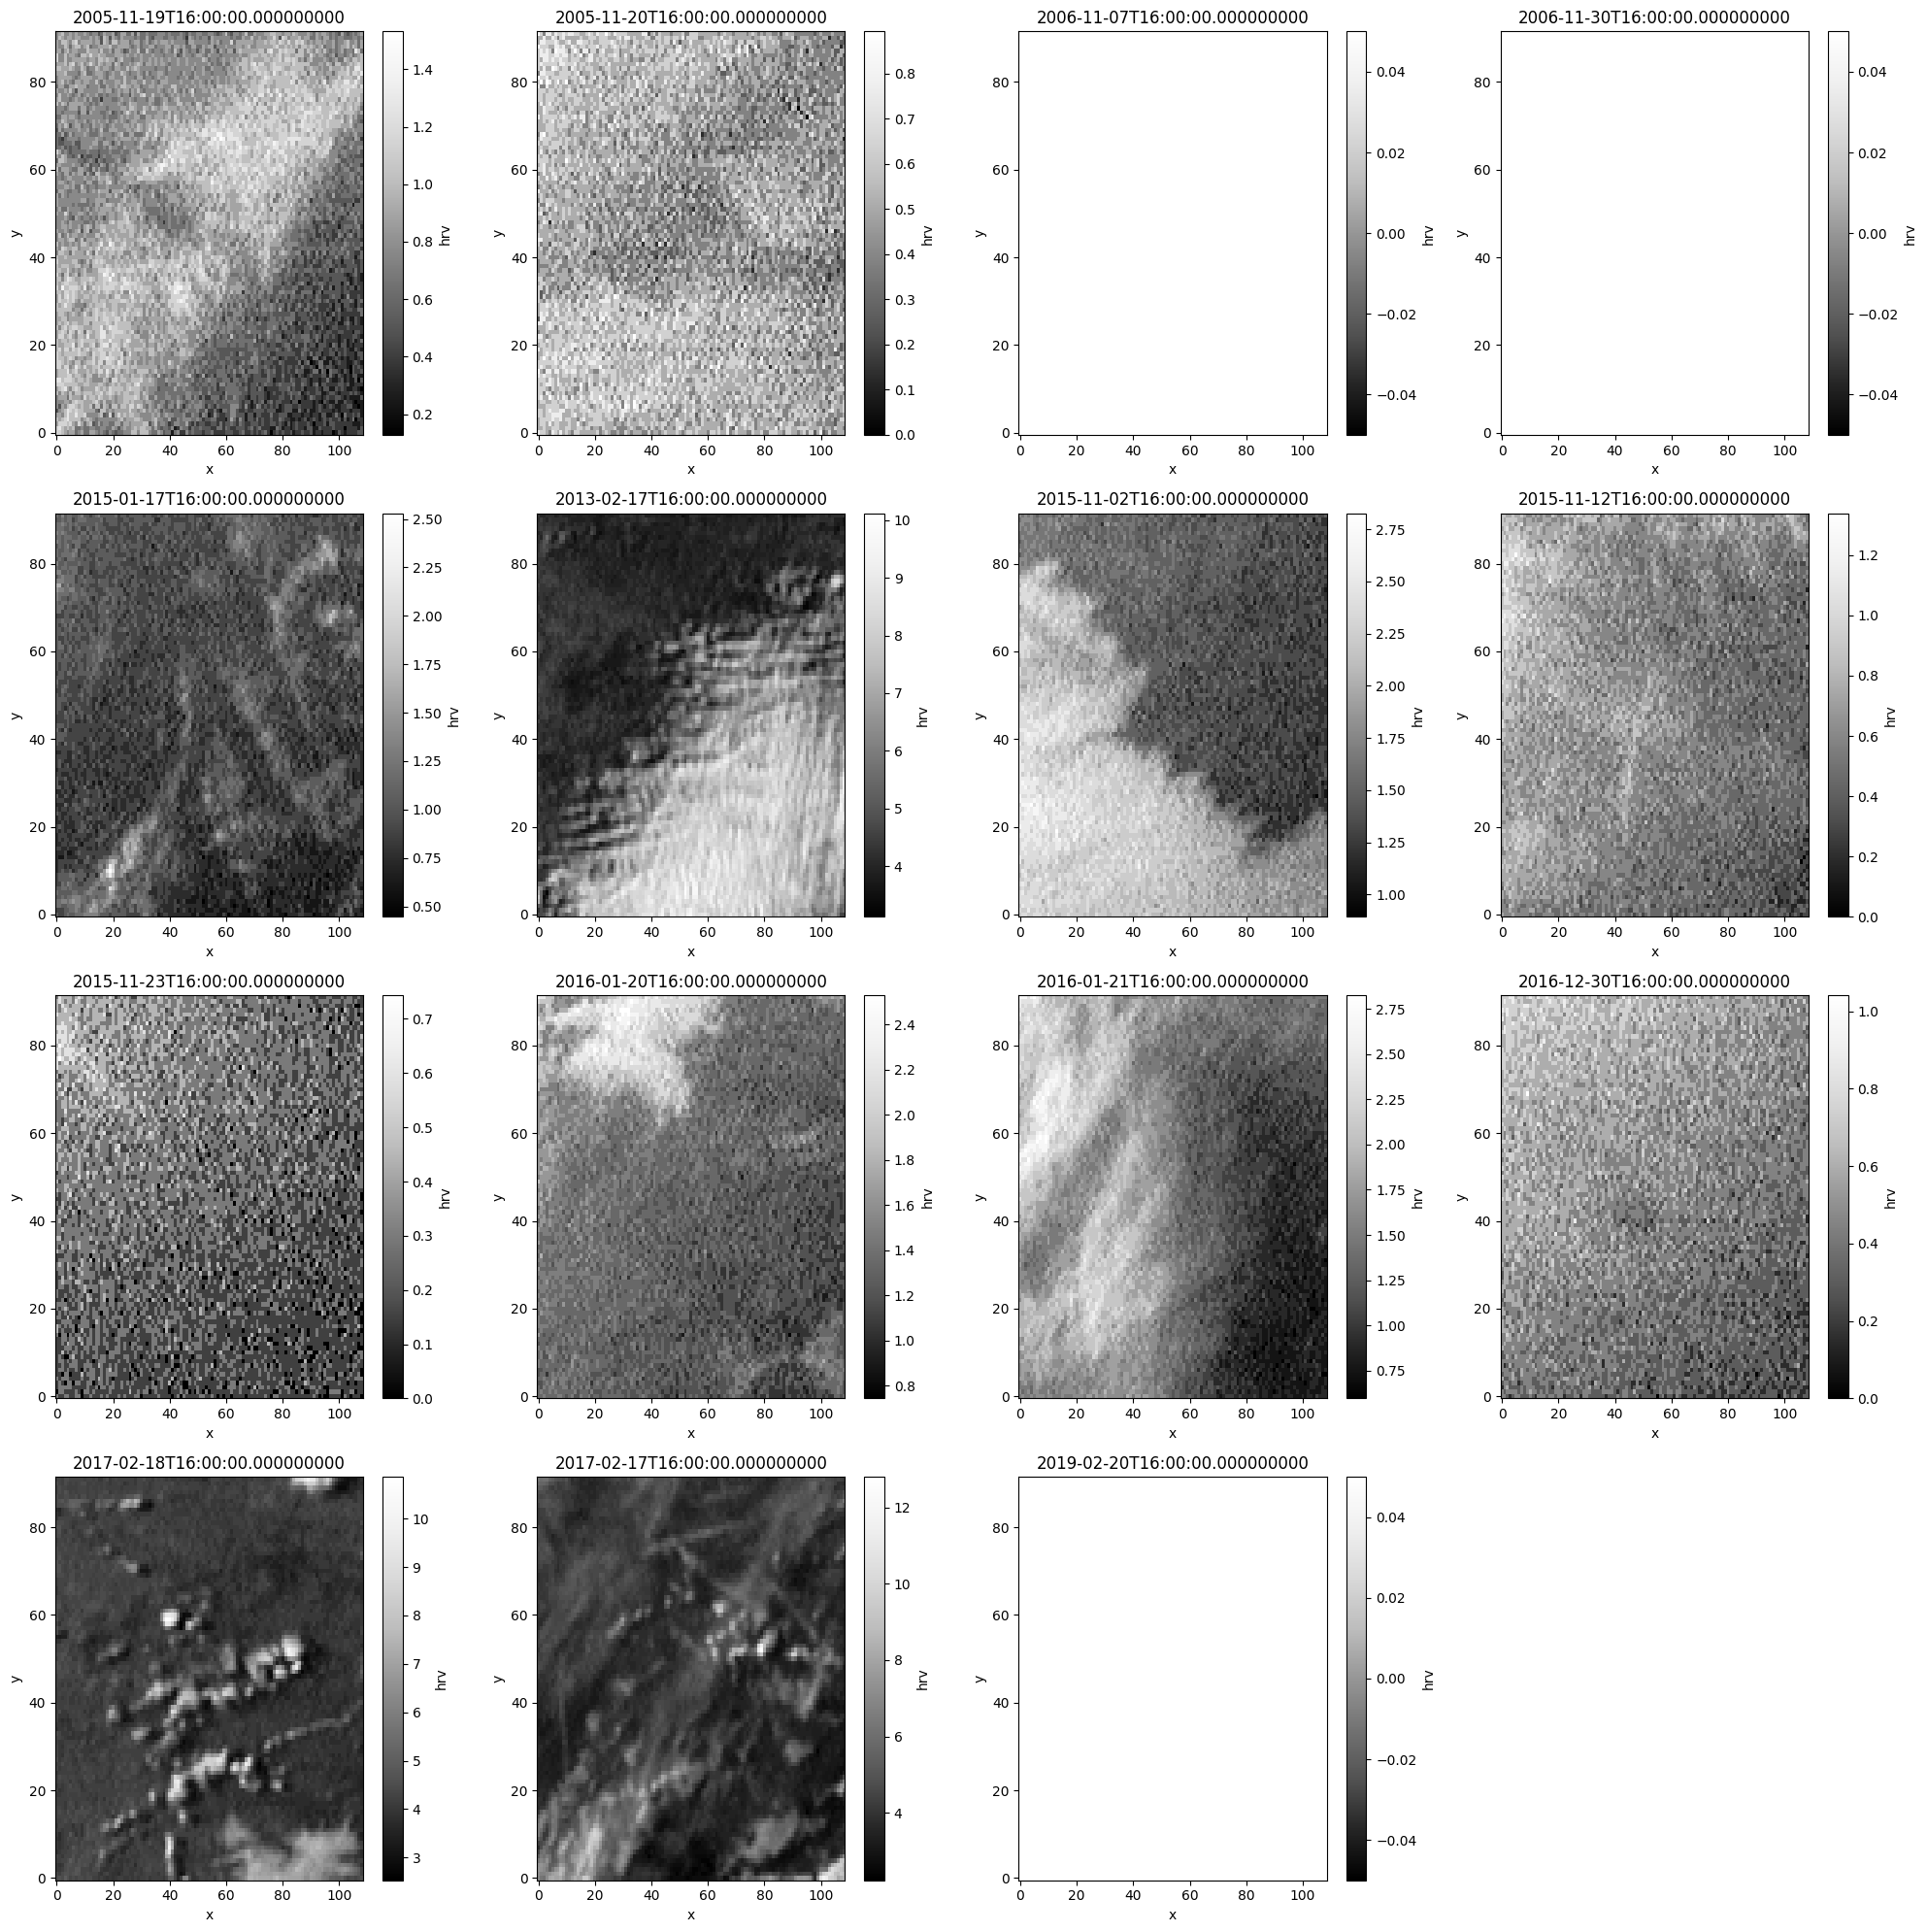

In [ ]:
def load_dataarrays(dates, time_str, directory='.'):
    """
    Loads xarray DataArrays based on a list of dates and a specific time in 'HH:MM:SS' format.

    Parameters:
    - dates: List of strings with dates in the format 'DD/MM/YYYY'.
    - time_str: Time string in the format 'HH:MM:SS' (e.g., '09:00:00').
    - directory: Directory path where the .nc files are located.

    Returns:
    - List of xarray.DataArray objects for each provided date and time.

    Raises:
    - FileNotFoundError if no file is found for a given month.
    - ValueError if more than one file is found for a given month.
    """
    dataarrays = []
    
    # Convert the time_str to a time object
    time = datetime.strptime(time_str, "%H:%M:%S").time()

    for date_str in dates:
        try: 
            print("working on: " + date_str)
            # Convert date string to datetime object from 'DD/MM/YYYY' format
            date = datetime.strptime(date_str, "%d/%m/%Y")
            
            # Combine the date and time into a full datetime object
            full_datetime = datetime.combine(date, time)
            
            # Format filename as 'hrv_lrYYYYMM.nc'
            filename_pattern = f"hrv_lr{date.strftime('%Y%m')}.nc"
            matching_files = [f for f in os.listdir(directory) if f.startswith('hrv_lr') and f.endswith('.nc') and f == filename_pattern]
            print(matching_files)
            # Check if we found exactly one matching file
            if len(matching_files) == 0:
                # raise FileNotFoundError(f"No file found for date {date_str}")
                filename_pattern = f"hrv_{date.strftime('%Y%m')}.nc"
                matching_files = [f for f in os.listdir(directory) if f.startswith('hrv_lr') and f.endswith('.nc') and f == filename_pattern]
                if len(matching_files) == 0:
                    with open("error_log.txt", "a") as error_file:
                        error_message = f"No datarray. File: {matching_files} Date: {date_str} Time: {time_str}\n"
                        error_file.write(error_message)

            elif len(matching_files) > 1:
                raise ValueError(f"Multiple files found for date {date_str}")
            
            # Open the file and select the data array for the specific date and time
            filepath = os.path.join(directory, matching_files[0])
            dataset = xr.open_dataset(filepath)
            
            # Select data for the specific date and time and append to the list
            dataarray = dataset.hrv.sel(time=full_datetime)
            dataarrays.append(dataarray)
        except Exception as e:
            print(f"File: {matching_files} Date: {date_str} Time: {time_str}  Unexpected error: {e}")
            with open("error_log.txt", "a") as error_file:
                error_message = f"File: {matching_files} Date: {date_str} Time: {time_str} Unexpected error: {e}\n"
                error_file.write(error_message)
    return dataarrays

def plot_dataarrays_at_same_datetime(dataarrays):
    num_dataarrays = len(dataarrays)
    
    # Calculate the number of rows and columns for subplots
    cols = int(np.ceil(np.sqrt(num_dataarrays)))  # Number of columns
    rows = int(np.ceil(num_dataarrays / cols))    # Number of rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), dpi=100)
    axes = axes.flatten() if num_dataarrays > 1 else [axes]  # Flatten axes if more than one subplot

    for i, ax in enumerate(axes):
        if i < num_dataarrays:
            dataarrays[i].plot(ax=ax, add_colorbar=True, cmap=cmap)  # Plot the DataArray on the current axis
            ax.set_title(f'{dataarrays[i].time.values.astype(str)}')
        else:
            ax.axis('off')  # Hide unused subplots if the number of DataArrays is less than the number of subplots

    plt.tight_layout()
    plt.show()

dates = [
    "19/11/2005",
    "20/11/2005",
    "07/11/2006",
    "30/11/2006",
    "19/02/2007",
    "17/01/2015",
    "17/02/2013",
    "02/11/2015",
    "12/11/2015",
    "23/11/2015",
    "20/01/2016",
    "21/01/2016",
    "30/12/2016",
    "18/02/2017",
    "17/02/2017",
    "05/02/2019",
    "13/02/2019",
    "20/02/2019"
]
time_str = '16:00:00'

dataarrays = load_dataarrays(dates, time_str, directory='/home/plato/dl_cloudhole/sat_data')
plot_dataarrays_at_same_datetime(dataarrays)

# problems will be logged in error_log.txt